# Imports

In [ ]:
#datasets
import kagglehub

#EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

import torch.optim as optim
import torch.nn.functional as F

import random
import numpy as np
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device :{device}")

Using Device :cuda


# Exploratory Data Analysis

In [ ]:
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
attributes_df = pd.read_csv(path + '/list_attr_celeba.csv')
landmarks_df = pd.read_csv(path + '/list_landmarks_align_celeba.csv')

print("Attributes DataFrame loaded successfully with shape:", attributes_df.shape)
print("Landmarks DataFrame loaded successfully with shape:", landmarks_df.shape)

Attributes DataFrame loaded successfully with shape: (202599, 41)
Landmarks DataFrame loaded successfully with shape: (202599, 11)


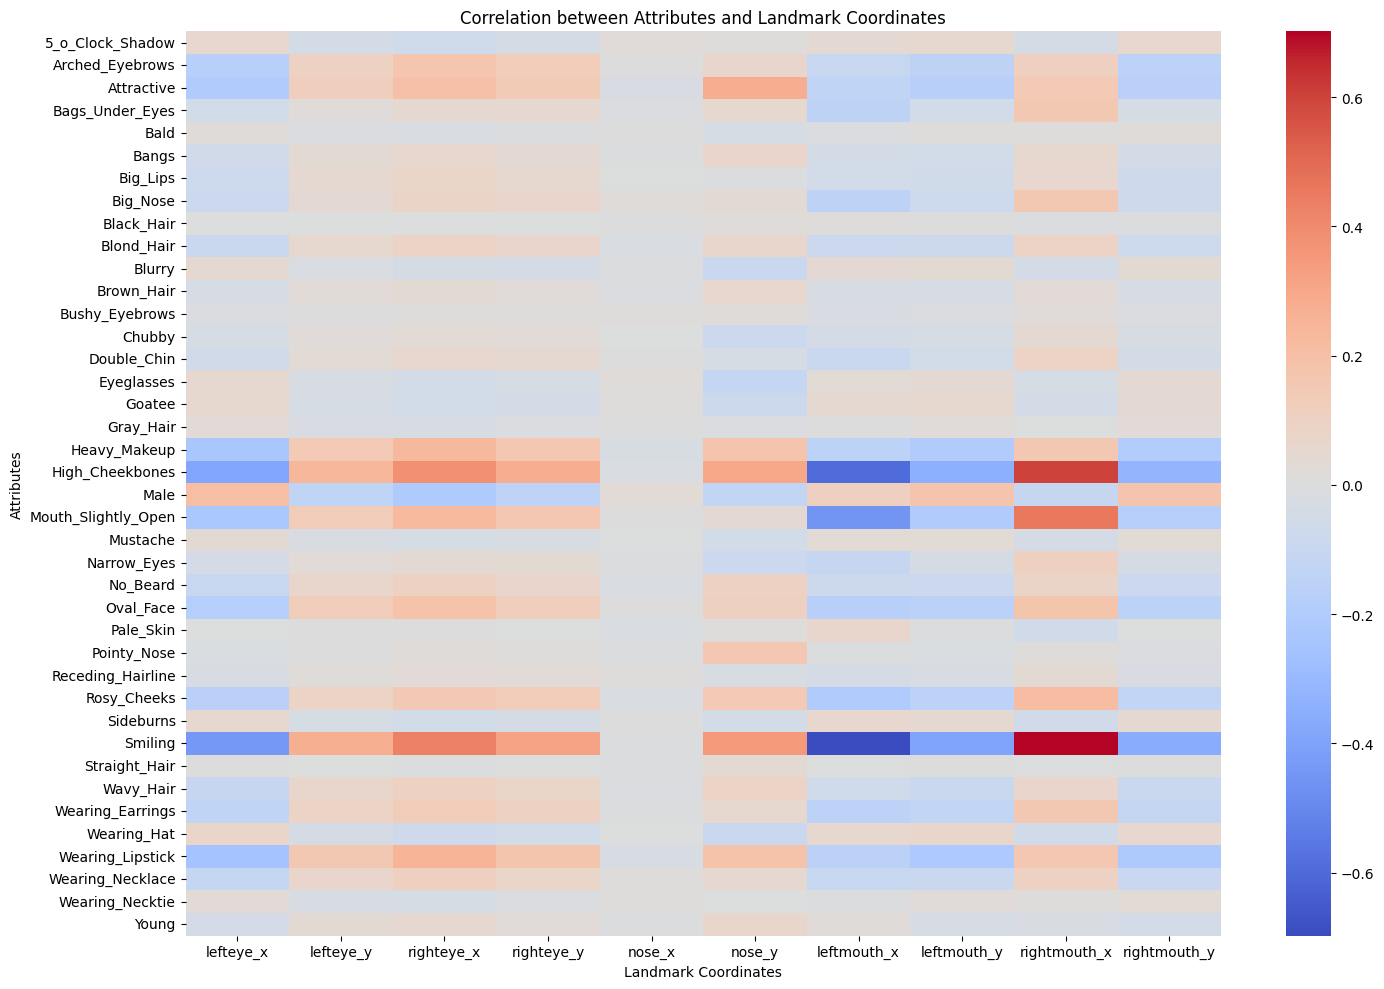

Top 20 Attribute-Landmark Correlations (Absolute Value):
rightmouth_x  Smiling                0.701598
leftmouth_x   Smiling                0.697335
rightmouth_x  High_Cheekbones        0.599059
leftmouth_x   High_Cheekbones        0.596368
rightmouth_x  Mouth_Slightly_Open    0.456999
leftmouth_x   Mouth_Slightly_Open    0.455470
lefteye_x     Smiling                0.442317
righteye_x    Smiling                0.432994
leftmouth_y   Smiling                0.393872
lefteye_x     High_Cheekbones        0.389285
righteye_x    High_Cheekbones        0.382874
rightmouth_y  Smiling                0.363847
nose_y        Smiling                0.351375
leftmouth_y   High_Cheekbones        0.346533
rightmouth_y  High_Cheekbones        0.322581
righteye_y    Smiling                0.314750
nose_y        High_Cheekbones        0.301953
              Attractive             0.276987
righteye_y    High_Cheekbones        0.275803
lefteye_y     Smiling                0.270344
dtype: float64


In [ ]:
merged_df = pd.merge(attributes_df, landmarks_df, on='image_id')
landmark_cols = [col for col in merged_df.columns if col.endswith('_x') or col.endswith('_y')]
attribute_cols = [col for col in merged_df.columns if col != 'image_id' and col not in landmark_cols]
numerical_df = merged_df[attribute_cols + landmark_cols]
correlation_matrix = numerical_df.corr()
attribute_landmark_correlation = correlation_matrix.loc[attribute_cols, landmark_cols]

# plot heat map
plt.figure(figsize=(15, 10))
sns.heatmap(attribute_landmark_correlation, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Attributes and Landmark Coordinates')
plt.xlabel('Landmark Coordinates')
plt.ylabel('Attributes')
plt.tight_layout()
plt.show()

abs_correlation = attribute_landmark_correlation.abs()
top_n = 20
top_correlations = abs_correlation.unstack().sort_values(ascending=False).head(top_n)

print(f"Top {top_n} Attribute-Landmark Correlations (Absolute Value):")
print(top_correlations)

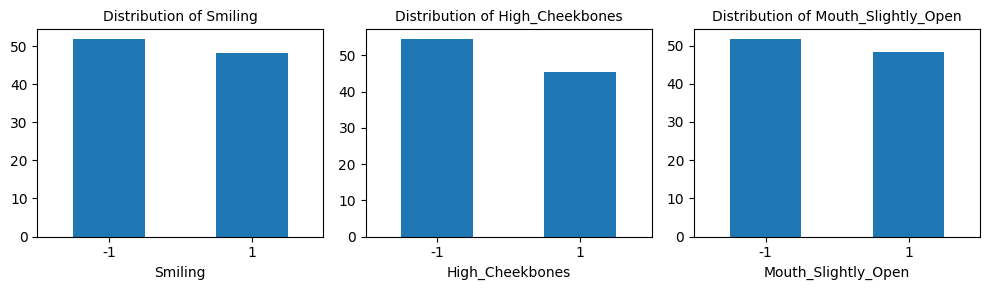

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(1, 3, 1)
(attributes_df['Smiling'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar')
plt.title('Distribution of Smiling', size =10)
plt.xticks(rotation=0)

plt.subplot(1, 3, 2)
(attributes_df['High_Cheekbones'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar')
plt.title('Distribution of High_Cheekbones', size =10)
plt.xticks(rotation=0)

plt.subplot(1, 3, 3)
(attributes_df['Mouth_Slightly_Open'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar')
plt.title('Distribution of Mouth_Slightly_Open', size =10)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Data Management

In [ ]:
class CelebAMultiTaskDataset(Dataset):
    def __init__(self, img_dir, attrs_df, landmarks_df, partition_df, partition_type='train', n_sample = 1000, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.file_list = partition_df[partition_df['partition'] == {'train': 0, 'val': 1, 'test': 2}[partition_type]]['image_id'].tolist()[:n_sample]
        self.attrs_df = attrs_df.set_index('image_id').loc[self.file_list]
        self.landmarks_df = landmarks_df.set_index('image_id').loc[self.file_list]

        # Convert attribute labels from -1/1 to 0/1
        self.attrs_df = (self.attrs_df + 1) / 2

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        attributes = torch.tensor(self.attrs_df.loc[img_name].values, dtype=torch.float32)
        landmarks = torch.tensor(self.landmarks_df.loc[img_name].values, dtype=torch.float32)
        original_width, original_height = 178, 218

        if self.transform:
            image = self.transform(image)

            landmarks[0::2] = landmarks[0::2] / original_width * 224.0
            landmarks[1::2] = landmarks[1::2] / original_height * 224.0
            landmarks = landmarks / 224.0

        return image, attributes, landmarks

In [ ]:
use_columns = ["image_id","High_Cheekbones","Mouth_Slightly_Open","Smiling"]

img_dir = path+'/img_align_celeba/img_align_celeba/'
attrs_df = pd.read_csv(path+'/list_attr_celeba.csv',usecols= use_columns )
partition_df = pd.read_csv(path+'/list_eval_partition.csv')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # ImageNet stats
])

train_dataset = CelebAMultiTaskDataset(img_dir, attrs_df, landmarks_df, partition_df, 'train', 12270, transform)
val_dataset = CelebAMultiTaskDataset(img_dir, attrs_df, landmarks_df, partition_df, 'val', 1592, transform)
test_dataset = CelebAMultiTaskDataset(img_dir, attrs_df, landmarks_df, partition_df, 'test', 1467, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Single Model

In [ ]:
class AttrTaskCelebAModel(nn.Module):
    def __init__(self, num_attributes):
        super(AttrTaskCelebAModel, self).__init__()

        self.backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for param in self.backbone.parameters():
          param.requires_grad = False

        self.backbone.fc = nn.Identity()

        num_features = 512
        self.attribute_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_attributes)
        )

    def forward(self, x):
        features = self.backbone(x)
        attribute_logits = self.attribute_head(features)

        return attribute_logits

class LandmarkTaskCelebAModel(nn.Module):
    def __init__(self, num_landmarks=10):
        super(LandmarkTaskCelebAModel, self).__init__()

        self.backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for param in self.backbone.parameters():
          param.requires_grad = False

        self.backbone.fc = nn.Identity()

        num_features = 512
        self.landmark_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_landmarks)
        )

    def forward(self, x):
        features = self.backbone(x)
        landmarks_pred = self.landmark_head(features)

        return landmarks_pred

# Multi-Task Learning Model

In [ ]:
class MultiTaskCelebAModel(nn.Module):
    def __init__(self, num_attributes, num_landmarks=10):
        super(MultiTaskCelebAModel, self).__init__()

        self.backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for param in self.backbone.parameters():
          param.requires_grad = False

        self.backbone.fc = nn.Identity()

        num_features = 512
        self.attribute_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_attributes)
        )

        self.landmark_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_landmarks)
        )

    def forward(self, x):
        features = self.backbone(x)
        attribute_logits = self.attribute_head(features)
        landmarks_pred = self.landmark_head(features)

        return attribute_logits, landmarks_pred

# Training Procedures

In [ ]:
def train_val(training_technique,num_epochs, learning_rate, attr_loss_weight, landmark_loss_weight, patience):
    # Hyperparameters
    num_epochs = num_epochs
    learning_rate = learning_rate

    # Loss weights (initial values)
    attr_loss_weight = attr_loss_weight
    landmark_loss_weight = landmark_loss_weight

    # Early stopping patience
    best_val_loss = float('inf')
    patience = patience
    patience_counter = 0 # Initialize patience counter

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model, loss functions, and optimizer
    if training_technique == 'mtl':
      model = MultiTaskCelebAModel(3).to(device)
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
      modelAttr = AttrTaskCelebAModel(3).to(device)
      modelLandmark = LandmarkTaskCelebAModel().to(device)
      optimizerAttr = optim.Adam(modelAttr.parameters(), lr=learning_rate)
      optimizerLandmark = optim.Adam(modelLandmark.parameters(), lr=learning_rate)

    # Loss functions
    attr_loss_fn = nn.BCEWithLogitsLoss()
    landmark_loss_fn = nn.MSELoss()

    # Initialize lists to store losses
    train_losses = []
    val_losses = []
    train_attr_losses = []
    val_attr_losses = []
    train_landmark_losses = []
    val_landmark_losses = []


    if training_technique == 'mtl':
      text_model = 'Multi-Task Learning'
    else:
      text_model = 'Single Model'
    print(f"\nStarting {text_model} training with Early Stopping...")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        if training_technique == 'mtl':
          model.train()
          current_optimizer = optimizer
        else:
          modelAttr.train()
          modelLandmark.train()
          current_optimizer_attr = optimizerAttr
          current_optimizer_landmark = optimizerLandmark


        running_train_loss = 0.0
        running_train_attr_loss = 0.0
        running_train_landmark_loss = 0.0
        for batch_idx, (images, attributes, landmarks) in enumerate(train_loader):
            images, attributes, landmarks = images.to(device), attributes.to(device), landmarks.to(device)

            # Forward pass
            if training_technique == 'mtl':
              current_optimizer.zero_grad()
              attr_logits, landmark_preds = model(images)

              # Calculate individual task losses
              loss_attr = attr_loss_fn(attr_logits, attributes)
              loss_landmark = landmark_loss_fn(landmark_preds, landmarks)

              # Combine losses
              total_loss = (attr_loss_weight * loss_attr) + (landmark_loss_weight * loss_landmark)

              # Backward pass and optimize
              total_loss.backward()
              current_optimizer.step()

              # Accumulate training loss
              running_train_loss += total_loss.item()
              running_train_attr_loss += loss_attr.item()
              running_train_landmark_loss += loss_landmark.item()

            else: # Single models training
              # Train Attribute Model
              current_optimizer_attr.zero_grad()
              attr_logits = modelAttr(images)
              loss_attr = attr_loss_fn(attr_logits, attributes)
              loss_attr.backward()
              current_optimizer_attr.step()
              running_train_attr_loss += loss_attr.item()

              # Train Landmark Model
              current_optimizer_landmark.zero_grad()
              landmark_preds = modelLandmark(images)
              loss_landmark = landmark_loss_fn(landmark_preds, landmarks)
              loss_landmark.backward()
              current_optimizer_landmark.step()
              running_train_landmark_loss += loss_landmark.item()
              total_loss = (attr_loss_weight * loss_attr) + (landmark_loss_weight * loss_landmark)
              running_train_loss += total_loss.item()

        # Calculate average training loss for the epoch
        avg_train_attr_loss = running_train_attr_loss / len(train_loader)
        avg_train_landmark_loss = running_train_landmark_loss / len(train_loader)
        avg_train_loss = running_train_loss / len(train_loader)

        # Store training losses
        train_losses.append(avg_train_loss)
        train_attr_losses.append(avg_train_attr_loss)
        train_landmark_losses.append(avg_train_landmark_loss)

        # Validation (similar loop, but call model.eval() and no gradient updates)
        # --- Validation Phase ---

        if training_technique == 'mtl':
          model.eval()
        else:
          modelAttr.eval()
          modelLandmark.eval()

        running_val_loss = 0.0
        running_val_attr_loss = 0.0
        running_val_landmark_loss = 0.0
        with torch.no_grad():
          for batch_idx, (images, attributes, landmarks) in enumerate(val_loader):
            images, attributes, landmarks = images.to(device), attributes.to(device), landmarks.to(device)

            # Forward pass
            if training_technique == 'mtl':
              attr_logits, landmark_preds = model(images)
            else:
              attr_logits = modelAttr(images)
              landmark_preds = modelLandmark(images)


            # Calculate individual task losses
            loss_attr = attr_loss_fn(attr_logits, attributes)
            loss_landmark = landmark_loss_fn(landmark_preds, landmarks)

            # Accumulate validation loss
            running_val_attr_loss += loss_attr.item()
            running_val_landmark_loss += loss_landmark.item()
            total_loss = (attr_loss_weight * loss_attr) + (landmark_loss_weight * loss_landmark)
            running_val_loss += total_loss.item()


        # Calculate average validation loss for the epoch
        avg_val_attr_loss = running_val_attr_loss / len(val_loader)
        avg_val_landmark_loss = running_val_landmark_loss / len(val_loader)
        avg_val_loss = running_val_loss / len(val_loader)


        # Store validation losses
        val_attr_losses.append(avg_val_attr_loss)
        val_landmark_losses.append(avg_val_landmark_loss)
        val_losses.append(avg_val_loss)

        loss_history = {'train_losses':train_losses,
             'val_losses':val_losses,
             'train_attr_losses':train_attr_losses,
             'val_attr_losses':val_attr_losses,
             'train_landmark_losses':train_landmark_losses,
             'val_landmark_losses':val_landmark_losses
             }

        print(f"Epoch {epoch+1}/{num_epochs}")
        if training_technique == 'mtl':
            print(f"Train Loss: {avg_train_loss:.4f}, Attr Loss: {avg_train_attr_loss:.4f}, Landmark Loss: {avg_train_landmark_loss:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}, Attr Loss: {avg_val_attr_loss:.4f}, Landmark Loss: {avg_val_landmark_loss:.4f}")
        else:
            print(f"Train Loss: {avg_train_loss:.4f}, Train Attr Loss: {avg_train_attr_loss:.4f}, Train Landmark Loss: {avg_train_landmark_loss:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f},Val Attr Loss: {avg_val_attr_loss:.4f}, Val Landmark Loss: {avg_val_landmark_loss:.4f}")

        # early stop
        if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          patience_counter = 0
        else:
          patience_counter += 1
          if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    print("\nTraining complete.")

    if training_technique == 'mtl':
      return model, loss_history
    else:
      return modelAttr, modelLandmark, loss_history

In [ ]:
def plot_training_curves(title, data):

  plt.figure(figsize=(18,7)) # Adjust figure size for a single column layout

  # Get the actual number of epochs that were run
  completed_epochs = len(data['train_losses'])

  # Plot Total Loss
  plt.subplot(1, 3, 1)
  plt.plot(range(1, completed_epochs + 1), data['train_losses'], label='Train Total Loss')
  plt.plot(range(1, completed_epochs + 1), data['val_losses'], label='Val Total Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Total Loss per Epoch')
  plt.legend()

  # Plot Attribute Loss
  plt.subplot(1, 3, 2)
  plt.plot(range(1, completed_epochs + 1), data['train_attr_losses'], label='Train Attr Loss')
  plt.plot(range(1, completed_epochs + 1), data['val_attr_losses'], label='Val Attr Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Attr Loss per Epoch')
  plt.legend()

  # Plot Landmark Loss
  plt.subplot(1, 3, 3)
  plt.plot(range(1, completed_epochs + 1), data['train_landmark_losses'], label='Train Landmark Loss')
  plt.plot(range(1, completed_epochs + 1), data['val_landmark_losses'], label='Val Landmark Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(' Landmark Loss per Epoch')
  plt.legend()

  plt.tight_layout()
  plt.suptitle('training resulte of '+title)
  plt.show()

Using device: cuda

Starting Multi-Task Learning training with Early Stopping...
Epoch 1/15
Train Loss: 28.1620, Attr Loss: 0.5509, Landmark Loss: 0.0062
Val Loss: 25.3975, Attr Loss: 0.5040, Landmark Loss: 0.0020
Epoch 2/15
Train Loss: 25.4221, Attr Loss: 0.5056, Landmark Loss: 0.0014
Val Loss: 25.8721, Attr Loss: 0.5149, Landmark Loss: 0.0013
Epoch 3/15
Train Loss: 24.5305, Attr Loss: 0.4884, Landmark Loss: 0.0011
Val Loss: 24.3496, Attr Loss: 0.4847, Landmark Loss: 0.0011
Epoch 4/15
Train Loss: 24.0343, Attr Loss: 0.4788, Landmark Loss: 0.0009
Val Loss: 24.9176, Attr Loss: 0.4965, Landmark Loss: 0.0009
Epoch 5/15
Train Loss: 23.6990, Attr Loss: 0.4724, Landmark Loss: 0.0008
Val Loss: 23.9785, Attr Loss: 0.4780, Landmark Loss: 0.0008
Epoch 6/15
Train Loss: 23.1749, Attr Loss: 0.4622, Landmark Loss: 0.0007
Val Loss: 24.4002, Attr Loss: 0.4867, Landmark Loss: 0.0006
Epoch 7/15
Train Loss: 23.0285, Attr Loss: 0.4594, Landmark Loss: 0.0006
Val Loss: 23.5353, Attr Loss: 0.4692, Landmark L

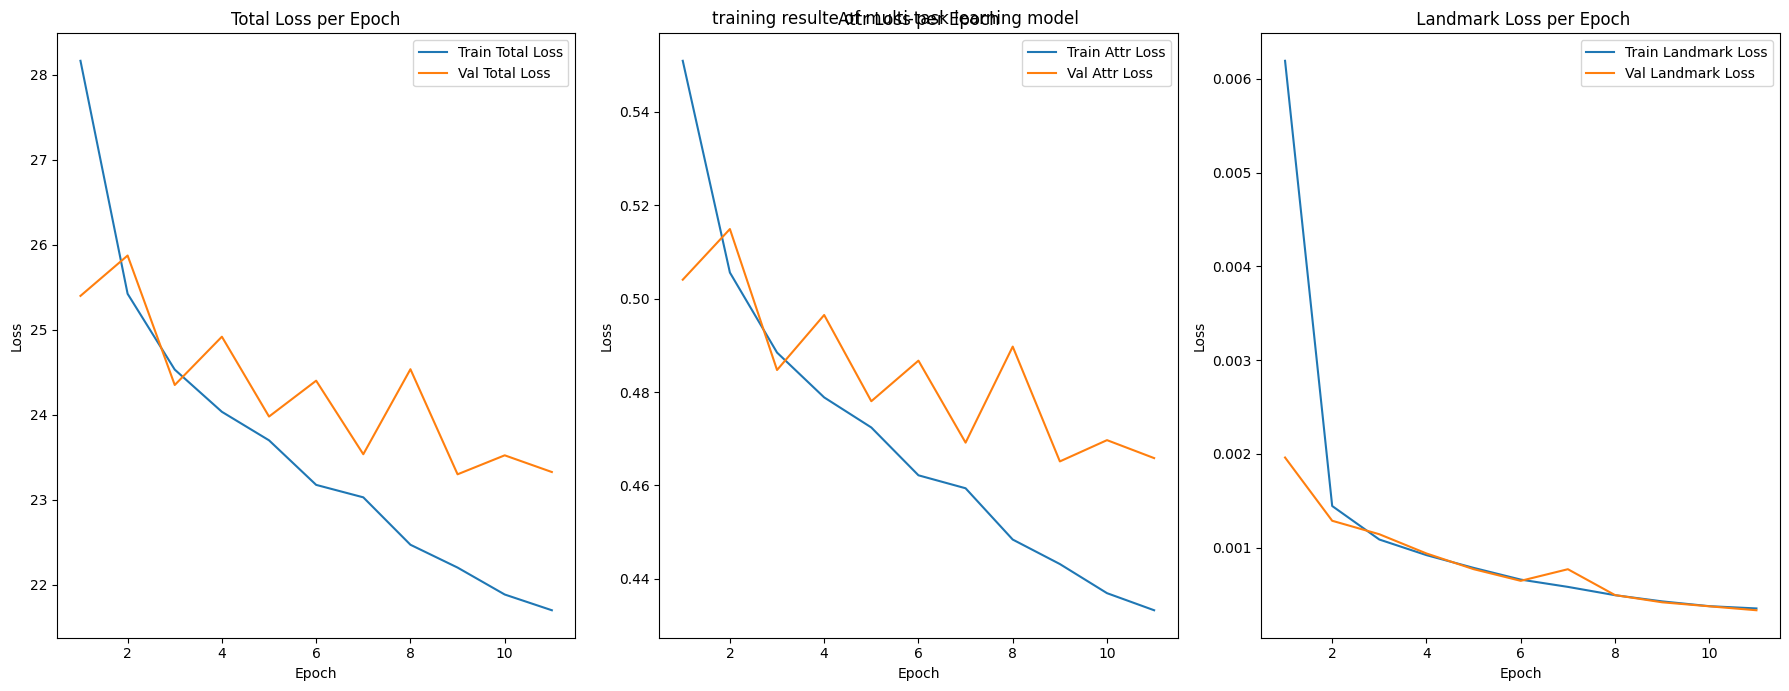

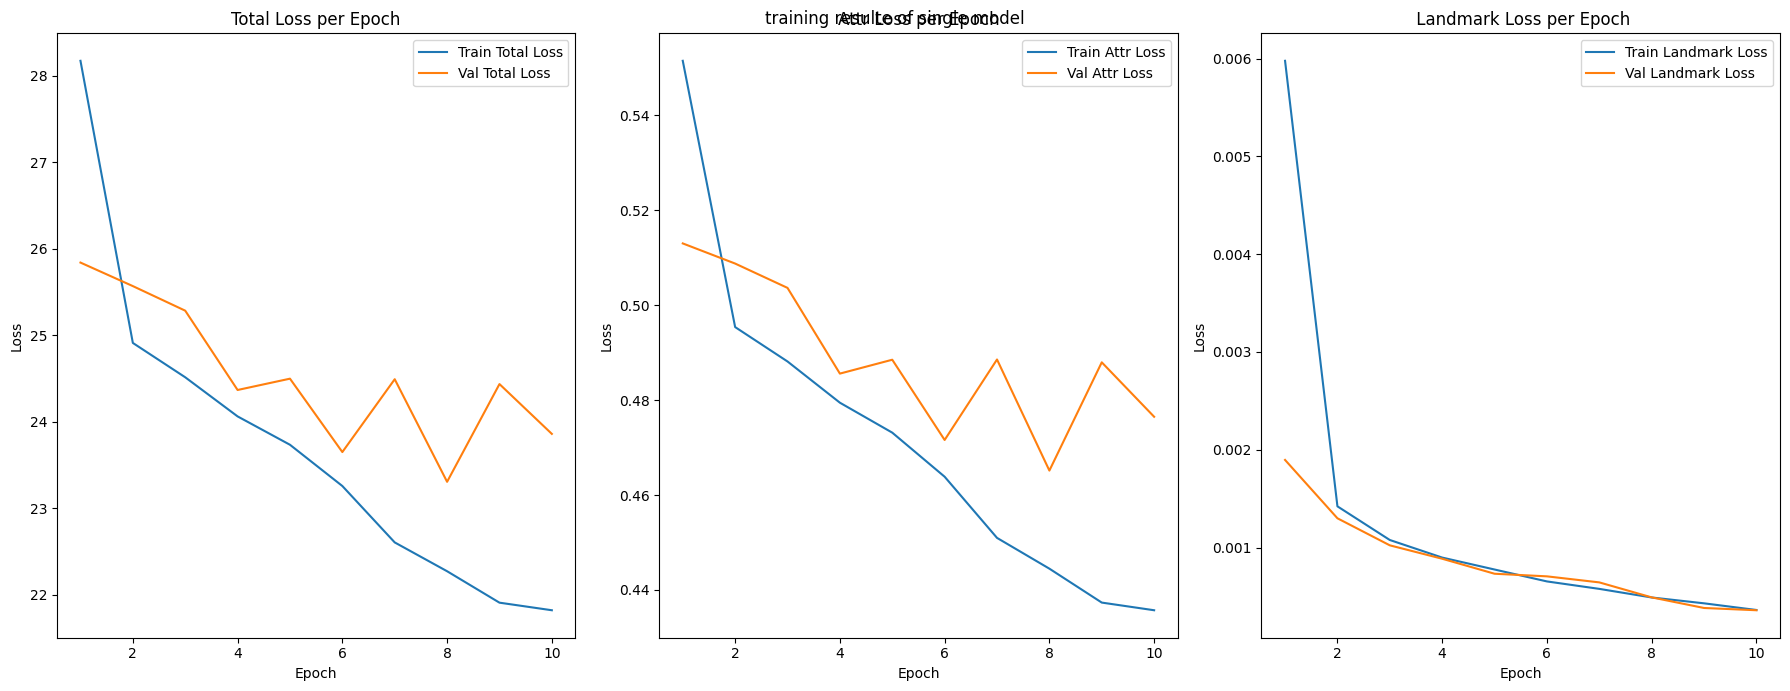

In [ ]:
torch.manual_seed(77)
np.random.seed(77)
random.seed(77)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(77)

multiTask_model, multi_loss_history = train_val(training_technique = 'mtl',
                                          num_epochs = 15,
                                          learning_rate = 0.001,
                                          attr_loss_weight= 50.0,
                                          landmark_loss_weight= 100.0,
                                          patience= 2)

modelAttr, modelLandmark, single_loss_history = train_val(training_technique = 'single',
                                                   num_epochs = 15,
                                                   learning_rate = 0.001,
                                                   attr_loss_weight= 50,
                                                   landmark_loss_weight= 100,
                                                   patience= 2)

plot_training_curves(title = 'multi-task learning model',data = multi_loss_history)
plot_training_curves(title = 'single model',data = single_loss_history)

# Model Results

In [ ]:
def evaluate_attributes(y_true_attr: np.ndarray, y_pred_attr_logits: np.ndarray, threshold: float = 0.5):
    """
    Evaluates attribute recognition performance.

    Args:
        y_true_attr (np.ndarray): Ground truth binary attribute labels.
                                  Shape: (num_samples, num_attributes).
        y_pred_attr_logits (np.ndarray): Predicted attribute logits (raw outputs from the model's head).
                                       Shape: (num_samples, num_attributes).
        threshold (float): Threshold to convert logits/probabilities to binary predictions.

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    if not isinstance(y_true_attr, np.ndarray):
        y_true_attr = y_true_attr.cpu().numpy()
    if not isinstance(y_pred_attr_logits, np.ndarray):
        y_pred_attr_logits = y_pred_attr_logits.cpu().numpy()

    y_pred_attr_proba = 1 / (1 + np.exp(-y_pred_attr_logits))
    y_pred_attr_binary = (y_pred_attr_proba >= threshold).astype(int)

    num_attributes = y_true_attr.shape[1]

    per_attribute_accuracy = []
    per_attribute_f1 = []
    per_attribute_precision = []
    per_attribute_recall = []

    for i in range(num_attributes):
        true_labels = y_true_attr[:, i]
        pred_labels = y_pred_attr_binary[:, i]

        per_attribute_accuracy.append(accuracy_score(true_labels, pred_labels))
        per_attribute_f1.append(f1_score(true_labels, pred_labels, zero_division=0))
        per_attribute_precision.append(precision_score(true_labels, pred_labels, zero_division=0))
        per_attribute_recall.append(recall_score(true_labels, pred_labels, zero_division=0))

    macro_accuracy = np.mean(per_attribute_accuracy)
    macro_f1 = np.mean(per_attribute_f1)
    macro_precision = np.mean(per_attribute_precision)
    macro_recall = np.mean(per_attribute_recall)

    micro_f1 = f1_score(y_true_attr.flatten(), y_pred_attr_binary.flatten(), zero_division=0)
    micro_precision = precision_score(y_true_attr.flatten(), y_pred_attr_binary.flatten(), zero_division=0)
    micro_recall = recall_score(y_true_attr.flatten(), y_pred_attr_binary.flatten(), zero_division=0)

    metrics = {
        "macro_accuracy": macro_accuracy,
        "macro_f1_score": macro_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "micro_f1_score": micro_f1,
        "micro_precision": micro_precision,
        "micro_recall": micro_recall,
        "per_attribute_accuracy": per_attribute_accuracy,
        "per_attribute_f1_score": per_attribute_f1
    }
    return metrics

def evaluate_landmarks(y_true_landmarks: np.ndarray, y_pred_landmarks: np.ndarray):
    """
    Evaluates landmark localization performance using Mean Absolute Error (MAE) and Mean Squared Error (MSE).

    Args:
        y_true_landmarks (np.ndarray): Ground truth landmark coordinates.
                                      Shape: (num_samples, num_landmarks * 2).
        y_pred_landmarks (np.ndarray): Predicted landmark coordinates.
                                      Shape: (num_samples, num_landmarks * 2).

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    if not isinstance(y_true_landmarks, np.ndarray):
        y_true_landmarks = y_true_landmarks.cpu().numpy()
    if not isinstance(y_pred_landmarks, np.ndarray):
        y_pred_landmarks = y_pred_landmarks.cpu().numpy()

    mae = np.mean(np.abs(y_true_landmarks - y_pred_landmarks))
    mse = np.mean((y_true_landmarks - y_pred_landmarks)**2)
    rmse = np.sqrt(mse)

    metrics = {
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
    }
    return metrics

In [ ]:
def evaluate_model(training_technique='mtl'):
  all_true_attributes = []
  all_predicted_attribute_logits = []
  all_true_landmarks = []
  all_predicted_landmarks = []

  if training_technique == 'mtl':
    multiTask_model.eval()
    multiTask_model.to(device)
  else:
    modelAttr.eval()
    modelLandmark.eval()
    modelAttr.to(device)
    modelLandmark.to(device)

  with torch.no_grad():
      for images, attributes, landmarks in test_loader:
          images = images.to(device)
          attributes = attributes.to(device)
          landmarks = landmarks.to(device)

          if training_technique == 'mtl':
            attr_logits, landmark_preds = multiTask_model(images)
          else:
            attr_logits = modelAttr(images)
            landmark_preds = modelLandmark(images)

          all_true_attributes.append(attributes.cpu())
          all_predicted_attribute_logits.append(attr_logits.cpu())
          all_true_landmarks.append(landmarks.cpu())
          all_predicted_landmarks.append(landmark_preds.cpu())

  all_true_attributes = torch.cat(all_true_attributes).numpy()
  all_predicted_attribute_logits = torch.cat(all_predicted_attribute_logits).numpy()
  all_true_landmarks = torch.cat(all_true_landmarks).numpy()
  all_predicted_landmarks = torch.cat(all_predicted_landmarks).numpy()

  # --- Evaluate Attribute Recognition ---
  if training_technique == 'mtl':
    text_model = 'Multi-Task Learning'
  else:
    text_model = 'Single Model'

  print(f"--- Evaluating {text_model} Attribute Recognition ---")
  attribute_metrics = evaluate_attributes(all_true_attributes, all_predicted_attribute_logits, threshold=0.5)

  print(f"Macro Accuracy: {attribute_metrics['macro_accuracy']:.4f}")
  print(f"Macro Precision: {attribute_metrics['macro_precision']:.4f}")
  print(f"Macro Recall: {attribute_metrics['macro_recall']:.4f}")
  print(f"Macro F1-Score: {attribute_metrics['macro_f1_score']:.4f}")
  # print(f"Micro Precision: {attribute_metrics['micro_precision']:.4f}")
  # print(f"Micro Recall: {attribute_metrics['micro_recall']:.4f}")
  # print(f"Micro F1-Score: {attribute_metrics['micro_f1_score']:.4f}")

  # --- Evaluate Landmark Localization ---
  print(f"\n--- Evaluating {text_model} Landmark Localization ---")
  landmark_metrics = evaluate_landmarks(all_true_landmarks, all_predicted_landmarks)

  print(f"Mean Absolute Error (MAE): {landmark_metrics['mae']:.4f}")
  print(f"Mean Squared Error (MSE): {landmark_metrics['mse']:.4f}")
  print(f"Root Mean Squared Error (RMSE): {landmark_metrics['rmse']:.4f}")

In [ ]:
evaluate_model('mtl')
evaluate_model('single')

--- Evaluating Multi-Task Learning Attribute Recognition ---
Macro Accuracy: 0.7800
Macro Precision: 0.7914
Macro Recall: 0.7643
Macro F1-Score: 0.7776

--- Evaluating Multi-Task Learning Landmark Localization ---
Mean Absolute Error (MAE): 0.0128
Mean Squared Error (MSE): 0.0003
Root Mean Squared Error (RMSE): 0.0180


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


--- Evaluating Single Model Attribute Recognition ---
Macro Accuracy: 0.7694
Macro Precision: 0.8388
Macro Recall: 0.6717
Macro F1-Score: 0.7456

--- Evaluating Single Model Landmark Localization ---
Mean Absolute Error (MAE): 0.0137
Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0189


# Visualization Results

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


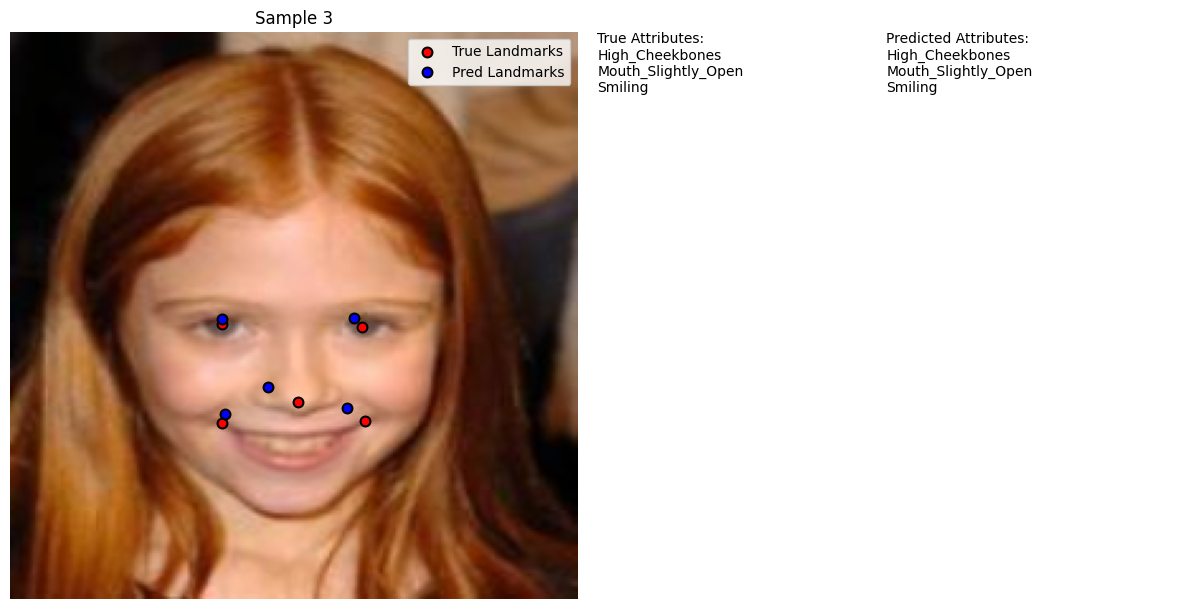

In [ ]:
images, true_attributes, true_landmarks = next(iter(test_loader))

images = images.to(device)
true_attributes = true_attributes.to(device)
true_landmarks = true_landmarks.to(device)


multiTask_model.eval()
with torch.no_grad():
    predicted_attribute_logits, predicted_landmarks = multiTask_model(images)


predicted_attribute_logits = predicted_attribute_logits.cpu()
predicted_landmarks = predicted_landmarks.cpu()

predicted_attribute_proba = F.sigmoid(predicted_attribute_logits)

threshold = 0.5
predicted_attribute_binary = (predicted_attribute_proba >= threshold).int()
predicted_attribute_binary_np = predicted_attribute_binary.numpy()
original_width, original_height = 178, 218
predicted_landmarks_scaled_224 = predicted_landmarks * 224.0
predicted_landmarks_original_scale_np = predicted_landmarks_scaled_224.numpy()


true_attributes_np = true_attributes.cpu().numpy()
true_landmarks_np = true_landmarks.cpu().numpy()
true_landmarks_original_scale_np = true_landmarks_np * 224.0
random_indices = np.random.choice(len(images), 1, replace=False)

for i in random_indices:
    image_tensor = images[i]

    true_attributes_sample = true_attributes_np[i]
    predicted_attribute_binary_sample = predicted_attribute_binary_np[i]

    true_landmarks_sample = true_landmarks_original_scale_np[i]
    predicted_landmarks_sample = predicted_landmarks_original_scale_np[i]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax_image = axes[0]
    ax_text = axes[1]

    ax_image.imshow(image_np)
    ax_image.set_title(f"Sample {i+1}")
    ax_image.axis('off')

    true_landmarks_x = true_landmarks_sample[0::2]
    true_landmarks_y = true_landmarks_sample[1::2]
    ax_image.scatter(true_landmarks_x, true_landmarks_y, c='red', s=50, label='True Landmarks', edgecolors='black', linewidth=1.5, zorder=2)

    predicted_landmarks_x = predicted_landmarks_sample[0::2]
    predicted_landmarks_y = predicted_landmarks_sample[1::2]
    ax_image.scatter(predicted_landmarks_x, predicted_landmarks_y, c='blue', s=50, label='Pred Landmarks', edgecolors='black', linewidth=1.5, zorder=2)

    ax_image.legend(loc='upper right')

    attribute_names = attrs_df.columns[1:].tolist()

    true_attr_lines = ["True Attributes:"]
    predicted_attr_lines = ["Predicted Attributes:"]

    for j, attr_name in enumerate(attribute_names):
        if true_attributes_sample[j] == 1:
            if predicted_attribute_binary_sample[j] == 0:
                true_attr_lines.append(f'{attr_name} (Not Predicted)')
            else:
                true_attr_lines.append(attr_name)

        if predicted_attribute_binary_sample[j] == 1:
             if true_attributes_sample[j] == 0:
                 predicted_attr_lines.append(f'{attr_name} (False Positive)')
             else:
                 # Predicted positive and true
                 predicted_attr_lines.append(attr_name)

    ax_text.text(0, 1, "\n".join(true_attr_lines) if len(true_attr_lines) > 1 else "True Attributes:\nNone",
                 fontsize=10, verticalalignment='top', transform=ax_text.transAxes)
    ax_text.text(0.5, 1, "\n".join(predicted_attr_lines) if len(predicted_attr_lines) > 1 else "Predicted Attributes:\nNone",
                 fontsize=10, verticalalignment='top', transform=ax_text.transAxes)
    ax_text.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close(fig)